In [1]:
from preprocess import *
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM, Activation
from keras.utils import to_categorical
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import sklearn.metrics as metrics
import numpy as np

Using TensorFlow backend.


In [2]:
wandb.init()
config = wandb.config

config.max_len = 32
config.buckets = 128

# Save data to array file first
save_data_to_array(max_len=config.max_len, n_mfcc=config.buckets)

#labels=np.array(["chirping_birds", "crickets", "crow", 
#                 "frog", "insects"])
labels=np.array(["AAT", "AHV", "AMA",
                 "ART", "ASI", "AVT",
                 "OPI", "OQU"])

'''Saving vectors of label - 'AAT': 100%|███████████████████████████████████████████████| 205/205 [00:03<00:00, 59.44it/s]
Saving vectors of label - 'AHV': 100%|█████████████████████████████████████████████████| 33/33 [00:00<00:00, 41.21it/s]
Saving vectors of label - 'AMA': 100%|█████████████████████████████████████████████████| 94/94 [00:02<00:00, 34.51it/s]
Saving vectors of label - 'ART': 100%|████████████████████████████████████████████████| 21/21 [00:00<00:00, 151.48it/s]
Saving vectors of label - 'ASI': 100%|████████████████████████████████████████████████| 17/17 [00:00<00:00, 146.96it/s]
Saving vectors of label - 'AVH': 100%|████████████████████████████████████████████████| 35/35 [00:00<00:00, 137.62it/s]
Saving vectors of label - 'AVT': 100%|██████████████████████████████████████████████| 965/965 [00:07<00:00, 129.08it/s]'''

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Saving vectors of label - 'OQU': 100%|█████████████████████████████████████████████| 2151/2151 [00:34<00:00, 62.65it/s]


"Saving vectors of label - 'AAT': 100%|███████████████████████████████████████████████| 205/205 [00:03<00:00, 59.44it/s]\nSaving vectors of label - 'AHV': 100%|█████████████████████████████████████████████████| 33/33 [00:00<00:00, 41.21it/s]\nSaving vectors of label - 'AMA': 100%|█████████████████████████████████████████████████| 94/94 [00:02<00:00, 34.51it/s]\nSaving vectors of label - 'ART': 100%|████████████████████████████████████████████████| 21/21 [00:00<00:00, 151.48it/s]\nSaving vectors of label - 'ASI': 100%|████████████████████████████████████████████████| 17/17 [00:00<00:00, 146.96it/s]\nSaving vectors of label - 'AVH': 100%|████████████████████████████████████████████████| 35/35 [00:00<00:00, 137.62it/s]\nSaving vectors of label - 'AVT': 100%|██████████████████████████████████████████████| 965/965 [00:07<00:00, 129.08it/s]"

In [3]:
# Loading train/test set
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test()

In [4]:
# Setting channels to 1 to generalize stereo sound to 1 channel
channels = 1
config.epochs = 7
config.batch_size = 100

# Number of classes
num_classes = 8
print(X_train.shape)
# Reshape X_train and X_test to include a 4th dimension (channels)
X_train = X_train.reshape(X_train.shape[0], config.buckets, config.max_len, channels)
X_test = X_test.reshape(X_test.shape[0], config.buckets, config.max_len, channels)
X_val = X_val.reshape(X_val.shape[0], config.buckets, config.max_len, channels)

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


(2480, 128, 32)


In [5]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#111111', '#222222', '#333333', '#444444', '#555555', '#666666', '#777777', '#888888']
    markers = ['o', 's', 'o', 's','o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()


In [6]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek

def run_sampler( X, y, sampler ) :
    print(X.shape)
    print(y.shape)

    X_samples, _, _, _ = X.shape

    d2_X = X.reshape((X_samples,config.buckets*config.max_len*channels))

    X_s, y_s = sampler.fit_sample(d2_X, y)

    #plot_2d_space(X_rus, y_rus, 'Random under-sampling')

    X_s = X_s.reshape((X_s.shape[0], config.buckets, config.max_len, channels))
    print("X_s", X_s.shape)
    print("Y_s", y_s.shape)
    
    return X_s, y_s

In [7]:
sampler = RandomUnderSampler()
sampler = RandomOverSampler()
smt = SMOTETomek()

X_train, y_train = run_sampler( X_train, y_train, smt )
X_test, y_test = run_sampler( X_test, y_test, smt )
X_val, y_val = run_sampler( X_val, y_val, smt )

(2480, 128, 32, 1)
(2480,)
X_s (8350, 128, 32, 1)
Y_s (8350,)
(1034, 128, 32, 1)
(1034,)
X_s (3408, 128, 32, 1)
Y_s (3408,)
(1654, 128, 32, 1)
(1654,)
X_s (5444, 128, 32, 1)
Y_s (5444,)


(8350, 128, 32, 1)


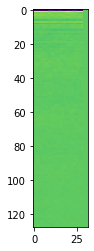

In [8]:
# Spectrogram visualized of 0th element
print(X_train.shape)
plt.imshow(X_train[200, :, :, 0])

In [9]:
# Getting vector number where each number corresponds to a label
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)
y_val_hot = to_categorical(y_val)

In [10]:
# Building the model
model = Sequential()

input_shape= (config.buckets, config.max_len, channels)

model.add(Conv2D(21, (3, 3), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (3, 3), padding="valid"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (3, 1), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(len(labels)))
model.add(Activation('softmax'))
model.summary()
# Conv2D: 
#    Filters: 32
#    Kernel_size: (3,3) (height/width of the 2D convolution window)     
'''model.add(Conv2D(32, (3, 3),
    input_shape=(config.buckets, config.max_len, channels),
    activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))'''


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 30, 21)       210       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 15, 21)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 63, 15, 21)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 13, 48)        9120      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 6, 48)         0         
_________________________________________________________________
activation_2 (Activation)    (None, 30, 6, 48)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 6, 48)       

"model.add(Conv2D(32, (3, 3),\n    input_shape=(config.buckets, config.max_len, channels),\n    activation='relu'))\n\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\n\nmodel.add(Flatten())\n\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dense(num_classes, activation='softmax'))"

In [11]:
# Configure CNN for training
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [12]:
wandb.init()
print(y_train_hot.shape)
print(labels.shape)
print(X_train.shape)
# Train the CNN model
#    X_train: Input data
#    y_train_hot: Target data
model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_val, y_val_hot), callbacks=[WandbCallback(data_type="image", labels=labels)])

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


(8350, 8)
(8,)
(8350, 128, 32, 1)

Train on 8350 samples, validate on 5444 samples
Epoch 1/7


5952/8350 [====================>.........] - ETA: 6:43 - loss: 5.8291 - accuracy: 0.03 - ETA: 4:07 - loss: 4.6948 - accuracy: 0.04 - ETA: 3:15 - loss: 4.0950 - accuracy: 0.07 - ETA: 2:53 - loss: 3.6382 - accuracy: 0.08 - ETA: 2:51 - loss: 3.3935 - accuracy: 0.09 - ETA: 2:42 - loss: 3.1831 - accuracy: 0.10 - ETA: 2:29 - loss: 3.0286 - accuracy: 0.13 - ETA: 2:26 - loss: 2.8987 - accuracy: 0.14 - ETA: 2:24 - loss: 2.8094 - accuracy: 0.16 - ETA: 2:20 - loss: 2.7036 - accuracy: 0.17 - ETA: 2:12 - loss: 2.6248 - accuracy: 0.18 - ETA: 2:05 - loss: 2.5598 - accuracy: 0.19 - ETA: 2:03 - loss: 2.5121 - accuracy: 0.19 - ETA: 2:06 - loss: 2.4607 - accuracy: 0.20 - ETA: 2:03 - loss: 2.4073 - accuracy: 0.21 - ETA: 1:59 - loss: 2.3768 - accuracy: 0.21 - ETA: 1:55 - loss: 2.3565 - accuracy: 0.20 - ETA: 1:51 - loss: 2.3206 - accuracy: 0.21 - ETA: 1:48 - loss: 2.2956 - accuracy: 0.21 - ETA: 1:45 - loss: 2.2716 - accuracy: 0.22 - ETA: 1:44 - loss: 2.2469 - accuracy: 0.22 - ETA: 1:41 - loss: 2.2273 - accu

8350/8350 [==============================] - ETA: 20s - loss: 1.2679 - accuracy: 0.540 - ETA: 20s - loss: 1.2644 - accuracy: 0.541 - ETA: 19s - loss: 1.2632 - accuracy: 0.542 - ETA: 19s - loss: 1.2606 - accuracy: 0.543 - ETA: 19s - loss: 1.2571 - accuracy: 0.544 - ETA: 18s - loss: 1.2546 - accuracy: 0.545 - ETA: 18s - loss: 1.2542 - accuracy: 0.545 - ETA: 18s - loss: 1.2522 - accuracy: 0.546 - ETA: 18s - loss: 1.2497 - accuracy: 0.547 - ETA: 17s - loss: 1.2484 - accuracy: 0.548 - ETA: 17s - loss: 1.2452 - accuracy: 0.549 - ETA: 17s - loss: 1.2423 - accuracy: 0.550 - ETA: 16s - loss: 1.2391 - accuracy: 0.551 - ETA: 16s - loss: 1.2385 - accuracy: 0.552 - ETA: 16s - loss: 1.2356 - accuracy: 0.553 - ETA: 16s - loss: 1.2348 - accuracy: 0.553 - ETA: 15s - loss: 1.2337 - accuracy: 0.554 - ETA: 15s - loss: 1.2306 - accuracy: 0.556 - ETA: 15s - loss: 1.2274 - accuracy: 0.557 - ETA: 14s - loss: 1.2241 - accuracy: 0.558 - ETA: 14s - loss: 1.2251 - accuracy: 0.559 - ETA: 14s - loss: 1.2229 - accur

5952/8350 [====================>.........] - ETA: 56s - loss: 0.6787 - accuracy: 0.781 - ETA: 1:05 - loss: 0.7181 - accuracy: 0.73 - ETA: 1:11 - loss: 0.6825 - accuracy: 0.76 - ETA: 1:16 - loss: 0.7389 - accuracy: 0.73 - ETA: 1:15 - loss: 0.7105 - accuracy: 0.72 - ETA: 1:10 - loss: 0.8364 - accuracy: 0.71 - ETA: 1:08 - loss: 0.8233 - accuracy: 0.72 - ETA: 1:07 - loss: 0.8052 - accuracy: 0.73 - ETA: 1:08 - loss: 0.7840 - accuracy: 0.73 - ETA: 1:07 - loss: 0.8118 - accuracy: 0.71 - ETA: 1:07 - loss: 0.7898 - accuracy: 0.72 - ETA: 1:08 - loss: 0.7853 - accuracy: 0.72 - ETA: 1:07 - loss: 0.7772 - accuracy: 0.73 - ETA: 1:04 - loss: 0.7655 - accuracy: 0.73 - ETA: 1:03 - loss: 0.7586 - accuracy: 0.73 - ETA: 1:03 - loss: 0.7582 - accuracy: 0.73 - ETA: 1:03 - loss: 0.7492 - accuracy: 0.73 - ETA: 1:02 - loss: 0.7415 - accuracy: 0.73 - ETA: 1:02 - loss: 0.7394 - accuracy: 0.73 - ETA: 1:02 - loss: 0.7429 - accuracy: 0.72 - ETA: 1:02 - loss: 0.7367 - accuracy: 0.73 - ETA: 1:01 - loss: 0.7228 - accu

8350/8350 [==============================] - ETA: 18s - loss: 0.5503 - accuracy: 0.813 - ETA: 17s - loss: 0.5497 - accuracy: 0.814 - ETA: 17s - loss: 0.5501 - accuracy: 0.813 - ETA: 17s - loss: 0.5483 - accuracy: 0.814 - ETA: 17s - loss: 0.5473 - accuracy: 0.815 - ETA: 16s - loss: 0.5474 - accuracy: 0.814 - ETA: 16s - loss: 0.5472 - accuracy: 0.814 - ETA: 16s - loss: 0.5472 - accuracy: 0.814 - ETA: 16s - loss: 0.5459 - accuracy: 0.814 - ETA: 15s - loss: 0.5458 - accuracy: 0.815 - ETA: 15s - loss: 0.5462 - accuracy: 0.814 - ETA: 15s - loss: 0.5455 - accuracy: 0.814 - ETA: 15s - loss: 0.5446 - accuracy: 0.815 - ETA: 14s - loss: 0.5436 - accuracy: 0.815 - ETA: 14s - loss: 0.5471 - accuracy: 0.815 - ETA: 14s - loss: 0.5487 - accuracy: 0.814 - ETA: 14s - loss: 0.5481 - accuracy: 0.814 - ETA: 13s - loss: 0.5477 - accuracy: 0.815 - ETA: 13s - loss: 0.5479 - accuracy: 0.814 - ETA: 13s - loss: 0.5484 - accuracy: 0.815 - ETA: 13s - loss: 0.5483 - accuracy: 0.815 - ETA: 13s - loss: 0.5485 - accur

5952/8350 [====================>.........] - ETA: 40s - loss: 0.5327 - accuracy: 0.718 - ETA: 52s - loss: 0.4668 - accuracy: 0.781 - ETA: 57s - loss: 0.4160 - accuracy: 0.822 - ETA: 1:09 - loss: 0.4176 - accuracy: 0.82 - ETA: 1:11 - loss: 0.3533 - accuracy: 0.85 - ETA: 1:09 - loss: 0.3228 - accuracy: 0.87 - ETA: 1:07 - loss: 0.3289 - accuracy: 0.87 - ETA: 1:04 - loss: 0.3350 - accuracy: 0.86 - ETA: 1:01 - loss: 0.3353 - accuracy: 0.86 - ETA: 1:00 - loss: 0.3539 - accuracy: 0.86 - ETA: 59s - loss: 0.3510 - accuracy: 0.8665 - ETA: 59s - loss: 0.3590 - accuracy: 0.862 - ETA: 59s - loss: 0.3744 - accuracy: 0.855 - ETA: 1:00 - loss: 0.3714 - accuracy: 0.85 - ETA: 59s - loss: 0.3712 - accuracy: 0.8521 - ETA: 1:00 - loss: 0.3737 - accuracy: 0.85 - ETA: 59s - loss: 0.3715 - accuracy: 0.8548 - ETA: 59s - loss: 0.3983 - accuracy: 0.845 - ETA: 58s - loss: 0.4000 - accuracy: 0.845 - ETA: 58s - loss: 0.3981 - accuracy: 0.843 - ETA: 58s - loss: 0.3922 - accuracy: 0.848 - ETA: 57s - loss: 0.3936 - ac

8350/8350 [==============================] - ETA: 17s - loss: 0.3535 - accuracy: 0.876 - ETA: 17s - loss: 0.3531 - accuracy: 0.876 - ETA: 16s - loss: 0.3525 - accuracy: 0.877 - ETA: 16s - loss: 0.3526 - accuracy: 0.877 - ETA: 16s - loss: 0.3520 - accuracy: 0.877 - ETA: 16s - loss: 0.3525 - accuracy: 0.877 - ETA: 15s - loss: 0.3528 - accuracy: 0.877 - ETA: 15s - loss: 0.3531 - accuracy: 0.877 - ETA: 15s - loss: 0.3529 - accuracy: 0.877 - ETA: 15s - loss: 0.3567 - accuracy: 0.876 - ETA: 14s - loss: 0.3560 - accuracy: 0.876 - ETA: 14s - loss: 0.3549 - accuracy: 0.876 - ETA: 14s - loss: 0.3546 - accuracy: 0.876 - ETA: 14s - loss: 0.3540 - accuracy: 0.876 - ETA: 14s - loss: 0.3536 - accuracy: 0.876 - ETA: 13s - loss: 0.3540 - accuracy: 0.876 - ETA: 13s - loss: 0.3534 - accuracy: 0.876 - ETA: 13s - loss: 0.3532 - accuracy: 0.877 - ETA: 13s - loss: 0.3528 - accuracy: 0.877 - ETA: 12s - loss: 0.3523 - accuracy: 0.877 - ETA: 12s - loss: 0.3519 - accuracy: 0.877 - ETA: 12s - loss: 0.3522 - accur

5952/8350 [====================>.........] - ETA: 56s - loss: 0.3655 - accuracy: 0.875 - ETA: 1:00 - loss: 0.3505 - accuracy: 0.87 - ETA: 1:00 - loss: 0.3172 - accuracy: 0.90 - ETA: 56s - loss: 0.2946 - accuracy: 0.9141 - ETA: 55s - loss: 0.2924 - accuracy: 0.906 - ETA: 56s - loss: 0.3076 - accuracy: 0.906 - ETA: 58s - loss: 0.3403 - accuracy: 0.888 - ETA: 57s - loss: 0.3361 - accuracy: 0.882 - ETA: 57s - loss: 0.3319 - accuracy: 0.888 - ETA: 57s - loss: 0.3126 - accuracy: 0.893 - ETA: 57s - loss: 0.3247 - accuracy: 0.892 - ETA: 55s - loss: 0.3161 - accuracy: 0.898 - ETA: 54s - loss: 0.3172 - accuracy: 0.899 - ETA: 54s - loss: 0.3305 - accuracy: 0.892 - ETA: 54s - loss: 0.3144 - accuracy: 0.900 - ETA: 54s - loss: 0.3027 - accuracy: 0.906 - ETA: 54s - loss: 0.2953 - accuracy: 0.909 - ETA: 54s - loss: 0.2916 - accuracy: 0.909 - ETA: 53s - loss: 0.2890 - accuracy: 0.909 - ETA: 53s - loss: 0.2907 - accuracy: 0.909 - ETA: 53s - loss: 0.2873 - accuracy: 0.910 - ETA: 52s - loss: 0.2896 - accu

8350/8350 [==============================] - ETA: 17s - loss: 0.2652 - accuracy: 0.910 - ETA: 17s - loss: 0.2671 - accuracy: 0.909 - ETA: 17s - loss: 0.2680 - accuracy: 0.909 - ETA: 16s - loss: 0.2690 - accuracy: 0.909 - ETA: 16s - loss: 0.2684 - accuracy: 0.909 - ETA: 16s - loss: 0.2682 - accuracy: 0.909 - ETA: 16s - loss: 0.2686 - accuracy: 0.909 - ETA: 16s - loss: 0.2693 - accuracy: 0.909 - ETA: 15s - loss: 0.2694 - accuracy: 0.909 - ETA: 15s - loss: 0.2690 - accuracy: 0.909 - ETA: 15s - loss: 0.2686 - accuracy: 0.909 - ETA: 15s - loss: 0.2678 - accuracy: 0.910 - ETA: 14s - loss: 0.2680 - accuracy: 0.910 - ETA: 14s - loss: 0.2676 - accuracy: 0.910 - ETA: 14s - loss: 0.2672 - accuracy: 0.911 - ETA: 14s - loss: 0.2666 - accuracy: 0.911 - ETA: 13s - loss: 0.2672 - accuracy: 0.911 - ETA: 13s - loss: 0.2669 - accuracy: 0.911 - ETA: 13s - loss: 0.2660 - accuracy: 0.911 - ETA: 13s - loss: 0.2663 - accuracy: 0.911 - ETA: 12s - loss: 0.2666 - accuracy: 0.911 - ETA: 12s - loss: 0.2674 - accur

5952/8350 [====================>.........] - ETA: 1:06 - loss: 0.1678 - accuracy: 0.93 - ETA: 1:04 - loss: 0.2700 - accuracy: 0.89 - ETA: 1:02 - loss: 0.2646 - accuracy: 0.90 - ETA: 1:01 - loss: 0.2708 - accuracy: 0.89 - ETA: 57s - loss: 0.2724 - accuracy: 0.8938 - ETA: 54s - loss: 0.2598 - accuracy: 0.906 - ETA: 56s - loss: 0.2392 - accuracy: 0.915 - ETA: 56s - loss: 0.2163 - accuracy: 0.925 - ETA: 58s - loss: 0.2550 - accuracy: 0.913 - ETA: 58s - loss: 0.2550 - accuracy: 0.912 - ETA: 58s - loss: 0.2440 - accuracy: 0.917 - ETA: 57s - loss: 0.2343 - accuracy: 0.921 - ETA: 57s - loss: 0.2284 - accuracy: 0.923 - ETA: 55s - loss: 0.2209 - accuracy: 0.928 - ETA: 55s - loss: 0.2209 - accuracy: 0.931 - ETA: 54s - loss: 0.2170 - accuracy: 0.931 - ETA: 54s - loss: 0.2248 - accuracy: 0.926 - ETA: 54s - loss: 0.2374 - accuracy: 0.918 - ETA: 54s - loss: 0.2367 - accuracy: 0.917 - ETA: 54s - loss: 0.2334 - accuracy: 0.917 - ETA: 54s - loss: 0.2303 - accuracy: 0.918 - ETA: 54s - loss: 0.2294 - accu

8350/8350 [==============================] - ETA: 16s - loss: 0.1982 - accuracy: 0.931 - ETA: 16s - loss: 0.1984 - accuracy: 0.931 - ETA: 16s - loss: 0.1999 - accuracy: 0.930 - ETA: 16s - loss: 0.1997 - accuracy: 0.930 - ETA: 15s - loss: 0.2006 - accuracy: 0.930 - ETA: 15s - loss: 0.2013 - accuracy: 0.930 - ETA: 15s - loss: 0.2018 - accuracy: 0.930 - ETA: 15s - loss: 0.2020 - accuracy: 0.930 - ETA: 14s - loss: 0.2016 - accuracy: 0.930 - ETA: 14s - loss: 0.2030 - accuracy: 0.929 - ETA: 14s - loss: 0.2031 - accuracy: 0.929 - ETA: 14s - loss: 0.2041 - accuracy: 0.928 - ETA: 13s - loss: 0.2039 - accuracy: 0.929 - ETA: 13s - loss: 0.2034 - accuracy: 0.929 - ETA: 13s - loss: 0.2040 - accuracy: 0.929 - ETA: 13s - loss: 0.2039 - accuracy: 0.929 - ETA: 13s - loss: 0.2033 - accuracy: 0.929 - ETA: 12s - loss: 0.2052 - accuracy: 0.928 - ETA: 12s - loss: 0.2054 - accuracy: 0.928 - ETA: 12s - loss: 0.2053 - accuracy: 0.928 - ETA: 12s - loss: 0.2048 - accuracy: 0.929 - ETA: 11s - loss: 0.2048 - accur

5952/8350 [====================>.........] - ETA: 41s - loss: 0.0671 - accuracy: 1.000 - ETA: 54s - loss: 0.0864 - accuracy: 0.984 - ETA: 54s - loss: 0.1287 - accuracy: 0.958 - ETA: 57s - loss: 0.1261 - accuracy: 0.960 - ETA: 57s - loss: 0.1970 - accuracy: 0.937 - ETA: 57s - loss: 0.2320 - accuracy: 0.916 - ETA: 58s - loss: 0.2276 - accuracy: 0.915 - ETA: 59s - loss: 0.2318 - accuracy: 0.910 - ETA: 58s - loss: 0.2233 - accuracy: 0.916 - ETA: 56s - loss: 0.2162 - accuracy: 0.918 - ETA: 57s - loss: 0.2074 - accuracy: 0.923 - ETA: 59s - loss: 0.1986 - accuracy: 0.924 - ETA: 59s - loss: 0.2137 - accuracy: 0.920 - ETA: 58s - loss: 0.2227 - accuracy: 0.919 - ETA: 58s - loss: 0.2180 - accuracy: 0.922 - ETA: 57s - loss: 0.2124 - accuracy: 0.925 - ETA: 57s - loss: 0.2034 - accuracy: 0.930 - ETA: 56s - loss: 0.1995 - accuracy: 0.930 - ETA: 55s - loss: 0.1986 - accuracy: 0.930 - ETA: 55s - loss: 0.1915 - accuracy: 0.934 - ETA: 56s - loss: 0.1875 - accuracy: 0.936 - ETA: 56s - loss: 0.1815 - accur

8350/8350 [==============================] - ETA: 18s - loss: 0.1699 - accuracy: 0.940 - ETA: 18s - loss: 0.1691 - accuracy: 0.940 - ETA: 17s - loss: 0.1689 - accuracy: 0.941 - ETA: 17s - loss: 0.1692 - accuracy: 0.940 - ETA: 17s - loss: 0.1694 - accuracy: 0.940 - ETA: 17s - loss: 0.1687 - accuracy: 0.941 - ETA: 16s - loss: 0.1684 - accuracy: 0.941 - ETA: 16s - loss: 0.1690 - accuracy: 0.941 - ETA: 16s - loss: 0.1689 - accuracy: 0.940 - ETA: 16s - loss: 0.1685 - accuracy: 0.940 - ETA: 15s - loss: 0.1687 - accuracy: 0.940 - ETA: 15s - loss: 0.1680 - accuracy: 0.941 - ETA: 15s - loss: 0.1678 - accuracy: 0.941 - ETA: 15s - loss: 0.1674 - accuracy: 0.941 - ETA: 14s - loss: 0.1677 - accuracy: 0.941 - ETA: 14s - loss: 0.1680 - accuracy: 0.941 - ETA: 14s - loss: 0.1687 - accuracy: 0.941 - ETA: 14s - loss: 0.1683 - accuracy: 0.941 - ETA: 14s - loss: 0.1685 - accuracy: 0.941 - ETA: 13s - loss: 0.1683 - accuracy: 0.941 - ETA: 13s - loss: 0.1677 - accuracy: 0.941 - ETA: 13s - loss: 0.1680 - accur

5952/8350 [====================>.........] - ETA: 39s - loss: 0.1887 - accuracy: 0.937 - ETA: 42s - loss: 0.1412 - accuracy: 0.953 - ETA: 40s - loss: 0.1149 - accuracy: 0.958 - ETA: 39s - loss: 0.1062 - accuracy: 0.960 - ETA: 39s - loss: 0.1352 - accuracy: 0.962 - ETA: 39s - loss: 0.1379 - accuracy: 0.958 - ETA: 39s - loss: 0.1287 - accuracy: 0.959 - ETA: 39s - loss: 0.1451 - accuracy: 0.957 - ETA: 39s - loss: 0.1424 - accuracy: 0.958 - ETA: 39s - loss: 0.1355 - accuracy: 0.959 - ETA: 39s - loss: 0.1280 - accuracy: 0.960 - ETA: 38s - loss: 0.1251 - accuracy: 0.958 - ETA: 38s - loss: 0.1334 - accuracy: 0.954 - ETA: 38s - loss: 0.1284 - accuracy: 0.955 - ETA: 38s - loss: 0.1503 - accuracy: 0.947 - ETA: 38s - loss: 0.1472 - accuracy: 0.949 - ETA: 38s - loss: 0.1496 - accuracy: 0.948 - ETA: 38s - loss: 0.1478 - accuracy: 0.947 - ETA: 37s - loss: 0.1500 - accuracy: 0.944 - ETA: 37s - loss: 0.1581 - accuracy: 0.940 - ETA: 37s - loss: 0.1529 - accuracy: 0.943 - ETA: 37s - loss: 0.1470 - accur

8350/8350 [==============================] - ETA: 15s - loss: 0.1489 - accuracy: 0.945 - ETA: 15s - loss: 0.1492 - accuracy: 0.945 - ETA: 14s - loss: 0.1488 - accuracy: 0.945 - ETA: 14s - loss: 0.1481 - accuracy: 0.945 - ETA: 14s - loss: 0.1476 - accuracy: 0.946 - ETA: 14s - loss: 0.1475 - accuracy: 0.946 - ETA: 14s - loss: 0.1475 - accuracy: 0.945 - ETA: 13s - loss: 0.1483 - accuracy: 0.945 - ETA: 13s - loss: 0.1480 - accuracy: 0.945 - ETA: 13s - loss: 0.1479 - accuracy: 0.945 - ETA: 13s - loss: 0.1475 - accuracy: 0.946 - ETA: 13s - loss: 0.1474 - accuracy: 0.946 - ETA: 12s - loss: 0.1470 - accuracy: 0.946 - ETA: 12s - loss: 0.1472 - accuracy: 0.946 - ETA: 12s - loss: 0.1467 - accuracy: 0.946 - ETA: 12s - loss: 0.1473 - accuracy: 0.946 - ETA: 12s - loss: 0.1468 - accuracy: 0.946 - ETA: 11s - loss: 0.1463 - accuracy: 0.946 - ETA: 11s - loss: 0.1459 - accuracy: 0.946 - ETA: 11s - loss: 0.1485 - accuracy: 0.946 - ETA: 11s - loss: 0.1485 - accuracy: 0.946 - ETA: 11s - loss: 0.1483 - accur

In [13]:
# Save the keras model
model.save("ant_cnn_model.h5")
print("Model has been saved.")

Model has been saved.


## Running the IntelliChirp Biophony CNN

In [14]:
from keras.models import load_model

# Load the model
loaded_model = load_model('ant_cnn_model.h5')

In [15]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 30, 21)       210       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 15, 21)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 63, 15, 21)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 13, 48)        9120      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 6, 48)         0         
_________________________________________________________________
activation_2 (Activation)    (None, 30, 6, 48)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 6, 48)        

[[343   0  12   1   0  47   0  23]
 [  0 138   0   0   0 173   5 110]
 [  0   0 242   0   0 180   0   4]
 [  0   0  15 320   0  91   0   0]
 [  4   0  33   0 359  30   0   0]
 [ 16   0   8   1   3 391   2   5]
 [  0   0  11   0   0  68 308  39]
 [  2   0   0   0   0  16   0 408]]
Accuracy for class AAT : [0.80516432]
Accuracy for class AHV : [0.32394366]
Accuracy for class AMA : [0.56807512]
Accuracy for class ART : [0.75117371]
Accuracy for class ASI : [0.842723]
Accuracy for class AVT : [0.91784038]
Accuracy for class OPI : [0.72300469]
Accuracy for class OQU : [0.95774648]
Overall Accuracy : 0.7362089201877934
Average Accuracy


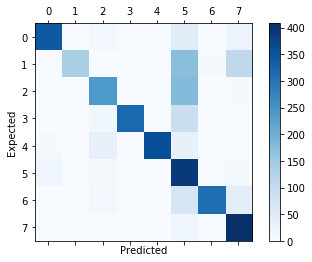

'[[ 24   0   0   0   0   0  10]\n [  1   4   0   0   0   0   3]\n [  0   0   5   0   0   0  16]\n [  2   0   0   0   0   0   1]\n [  0   0   0   0   0   0   6]\n [  0   0   0   0   0   2   3]\n [  1   0   1   1   0   0 194]]\nAccuracy for class AAT : [0.70588235]\nAccuracy for class AHV : [0.5]\nAccuracy for class AMA : [0.23809524]\nAccuracy for class ART : [0.]\nAccuracy for class ASI : [0.]\nAccuracy for class AVH : [0.4]\nAccuracy for class AVT : [0.98477157]\nOverall Accuracy : 0.8357664233576643'

In [16]:
y_pred_ohe = loaded_model.predict(X_test)  # shape=(n_samples, 12)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_labels)  # shape
print(confusion_matrix)
sum_avg = 0
for class_i in range(len(labels)) :
    indices = np.argwhere(y_test == class_i)
    sum = 0
    for index in indices:
        sum += (y_test[index] == y_pred_labels[index])
    if(len(indices) > 0) : mean = sum/len(indices)
    else : mean = "N/A"
    sum_avg += mean
    print("Accuracy for class", labels[class_i], ":", mean)
avg_mean = sum / len(labels)
    
print("Overall Accuracy :", np.mean(y_test == y_pred_labels))
print("Average Accuracy")

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

'''[[ 24   0   0   0   0   0  10]
 [  1   4   0   0   0   0   3]
 [  0   0   5   0   0   0  16]
 [  2   0   0   0   0   0   1]
 [  0   0   0   0   0   0   6]
 [  0   0   0   0   0   2   3]
 [  1   0   1   1   0   0 194]]
Accuracy for class AAT : [0.70588235]
Accuracy for class AHV : [0.5]
Accuracy for class AMA : [0.23809524]
Accuracy for class ART : [0.]
Accuracy for class ASI : [0.]
Accuracy for class AVH : [0.4]
Accuracy for class AVT : [0.98477157]
Overall Accuracy : 0.8357664233576643'''

In [17]:
from sklearn.metrics import classification_report, zero_one_loss

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

zero1loss = zero_one_loss(y_true=y_test, y_pred=y_pred_labels)

3408/3408 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 10s 3ms/step


In [18]:
print(classification_report(y_test, y_pred_bool))
print(zero1loss)

              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87       426
         1.0       1.00      0.32      0.49       426
         2.0       0.75      0.57      0.65       426
         3.0       0.99      0.75      0.86       426
         4.0       0.99      0.84      0.91       426
         5.0       0.39      0.92      0.55       426
         6.0       0.98      0.72      0.83       426
         7.0       0.69      0.96      0.80       426

    accuracy                           0.74      3408
   macro avg       0.84      0.74      0.74      3408
weighted avg       0.84      0.74      0.74      3408

0.2637910798122066


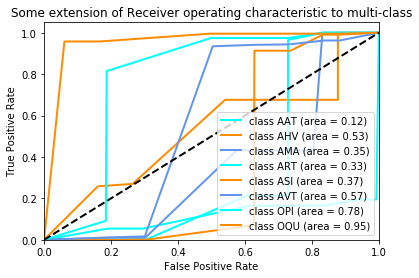

In [21]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_labels, pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_labels.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [20]:
## Running the model

n_mfcc = config.buckets
max_len = config.max_len
# convert file to wav2mfcc
# Mel-frequency cepstral coefficients
file_path = "./prediction/nature_sc.wav"
big_wave, sr = librosa.load(file_path, mono=True, sr=None)
#print(wave.shape, sr)

classification = []

for sec_index in range( int(big_wave.shape[0] / sr) ) :
    start_sec = sec_index
    end_sec = sec_index + 1
    
    sec_to_trim = np.array( [ float(start_sec), float(end_sec) ] )
    print(sec_to_trim)
    sec_to_trim = np.ceil( sec_to_trim * sr )

    wave = big_wave[int(sec_to_trim[0]) : int(sec_to_trim[1])]
    print(wave)

    wave = np.asfortranarray(wave[::3])
    mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=n_mfcc)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]

    # Convert wav to MFCC
    prediction_data = wav2mfcc('./prediction/nature_sc.wav')
    prediction_data = mfcc
    print(prediction_data.shape)
    #print(wav2mfcc())
    # Reshape to 4 dimensions
    prediction_data = prediction_data.reshape(1, config.buckets, config.max_len, channels)
    #prediction_data = prediction_data.reshape(1, 20, config.max_len, channels)

    # Run the model on the inputted file
    predicted = loaded_model.predict(prediction_data)

    # Output the prediction values for each class
    print ('PREDICTED VALUES')
    labels_indices = range(len(labels))
    max_value = 0
    max_value_index = 0
    for index in labels_indices:
        print('\n', labels[index], ": ", '%.08f' % predicted[0,index])
        if predicted[0,index] > max_value:
            max_value_index = index
            max_value = predicted[0,index]

    # Output the prediction
    if max_value < 0.5:
        print("GUESS: Nothing")
        classification.append( { "class" : "Nothing", "timestamp" : start_sec } )
    else:
        print('\n\nGUESS: ', labels[max_value_index])
        classification.append( { "class" : labels[max_value_index], "timestamp" : start_sec } )

print(classification)

[0. 1.]
[ 0.0000000e+00  1.5258789e-05  0.0000000e+00 ...  3.3020020e-02
  1.2680054e-02 -8.7432861e-03]
(128, 32)
PREDICTED VALUES

 AAT :  0.00000013

 AHV :  0.00000012

 AMA :  0.00000041

 ART :  0.00000041

 ASI :  0.00000019

 AVT :  0.98494315

 OPI :  0.01492917

 OQU :  0.00012637


GUESS:  AVT
[1. 2.]
[-0.03717041 -0.05769348 -0.06455994 ...  0.01766968  0.01895142
  0.01779175]
(128, 32)
PREDICTED VALUES

 AAT :  0.00005274

 AHV :  0.00000492

 AMA :  0.00000784

 ART :  0.00000611

 ASI :  0.00004145

 AVT :  0.99889284

 OPI :  0.00035723

 OQU :  0.00063691


GUESS:  AVT
[2. 3.]
[ 0.02345276  0.02101135  0.01712036 ... -0.01161194 -0.0141449
 -0.01431274]
(128, 32)
PREDICTED VALUES

 AAT :  0.00000014

 AHV :  0.00000081

 AMA :  0.00000069

 ART :  0.00000075

 ASI :  0.00000028

 AVT :  0.99999070

 OPI :  0.00000311

 OQU :  0.00000355


GUESS:  AVT
[3. 4.]
[-0.01583862 -0.01066589 -0.00762939 ... -0.0377655  -0.03556824
 -0.02685547]
(128, 32)
PREDICTED VALUES

 AAT

(128, 32)
PREDICTED VALUES

 AAT :  0.00003176

 AHV :  0.00006782

 AMA :  0.00002288

 ART :  0.00013291

 ASI :  0.01521447

 AVT :  0.92627555

 OPI :  0.05701942

 OQU :  0.00123521


GUESS:  AVT
[29. 30.]
[ 0.01919556  0.0135498   0.01724243 ... -0.00575256 -0.01502991
 -0.02742004]
(128, 32)
PREDICTED VALUES

 AAT :  0.00002857

 AHV :  0.00000291

 AMA :  0.00000015

 ART :  0.00029007

 ASI :  0.00029640

 AVT :  0.79416519

 OPI :  0.20509183

 OQU :  0.00012480


GUESS:  AVT
[30. 31.]
[-0.0322876  -0.0365448  -0.03544617 ... -0.0218811  -0.02978516
 -0.04052734]
(128, 32)
PREDICTED VALUES

 AAT :  0.00040708

 AHV :  0.00018729

 AMA :  0.00001118

 ART :  0.00108388

 ASI :  0.04779301

 AVT :  0.95046216

 OPI :  0.00004372

 OQU :  0.00001164


GUESS:  AVT
[31. 32.]
[-0.04328918 -0.03413391 -0.03421021 ...  0.05908203  0.06370544
  0.05949402]
(128, 32)
PREDICTED VALUES

 AAT :  0.00000139

 AHV :  0.00000012

 AMA :  0.00000011

 ART :  0.00000384

 ASI :  0.00001042

 A